# 1. Подключение библиотек

In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
from PIL import Image

# 2. Обработка данных

In [3]:
#функция для создания тестовой и тренировочной выборки
def get_data_frame(path):
    
    #формирование полных путей до картинок
    tmp_imgs_paths = open('/home/misha/Загрузки/food-101/' + path).read().split('\n')[:-1]
    full_paths = ['/home/misha/Загрузки/food-101/images/' + p + '.jpg' for p in tmp_imgs_paths]

    #формирование классов картинок
    labels = [p.split('/')[0] for p in tmp_imgs_paths]
    labels = np.array(labels)

    #перенос данных в дата фрейм
    data = pd.DataFrame()
    data['label'] = labels
    data['path'] = full_paths

    #перемешивание данных
    data = shuffle(data)
    
    return data

In [4]:
#формирование дата фреймов для тренировочной и тестовой выборки
df_train = get_data_frame('meta/train.txt')
df_test = get_data_frame('meta/test.txt')
df_train.head()

label                                               path
27778   filet_mignon  /home/misha/Загрузки/food-101/images/filet_mig...
15453  chicken_wings  /home/misha/Загрузки/food-101/images/chicken_w...
53788         paella  /home/misha/Загрузки/food-101/images/paella/35...
31924   french_toast  /home/misha/Загрузки/food-101/images/french_to...
25383        edamame  /home/misha/Загрузки/food-101/images/edamame/4...

# 3. Разведочный анализ данных
### Задачи:
1) Проверить правильную работу дата фреймов
2) Выяснить есть ли в датасете пропуски и устранить их
3) Найти и устранить выбросы в датасете
4) Исследовать распределения данных
5) Визуализировать данные

Используем метод describe(), чтобы убедиться, что в датасетах представлены все классы и все пути изображений уникальны

In [4]:
df_train.describe()

label                                               path
count    75750                                              75750
unique     101                                              75750
top     samosa  /home/misha/Загрузки/food-101/images/chocolate...
freq       750                                                  1

In [5]:
df_test.describe()

label                                               path
count      25250                                              25250
unique       101                                              25250
top     pancakes  /home/misha/Загрузки/food-101/images/baklava/3...
freq         250                                                  1

Убедимся, что в нашем датасете нет пропусков

In [6]:
df_train.isna().sum()

label    0
path     0
dtype: int64

In [7]:
df_train.isna().sum()

label    0
path     0
dtype: int64

Далее визуализируем информацию о количествах блюд каждого класса с помощью bar графиков

In [8]:
#функция для визуализации
def counts_of_classes_visual(data):
    #unique_labels - список уникальных значений столбца "label" дата фрейма
    unique_labels = list(set(data['label']))

    #задаем размер и количество колонок и строк для графика
    plt.figure(figsize=(20, 110))
    n_cols, n_rows = 1, 11

    #цикл для построения графика
    for i in range(1, 11):
        ax = plt.subplot(n_rows, n_cols, i)
        ax.bar(x=unique_labels[i * 10 : (i+1) * 10], 
                height=[list(data['label']).count(label) for label in unique_labels[i * 10 : (i+1) * 10]],
                width=0.8)


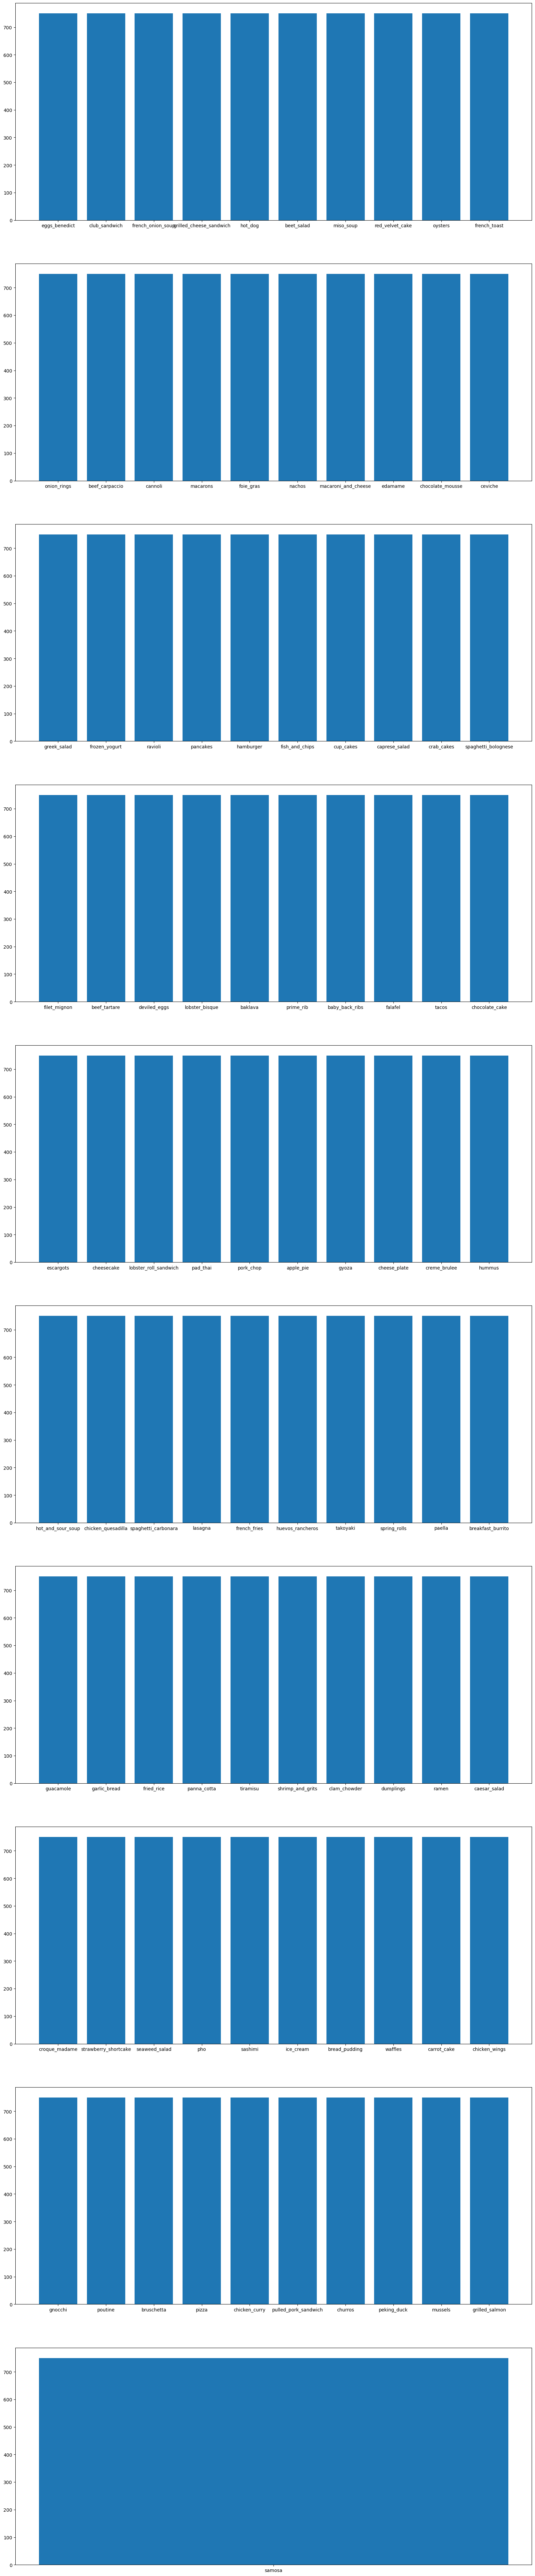

In [9]:
counts_of_classes_visual(df_train)

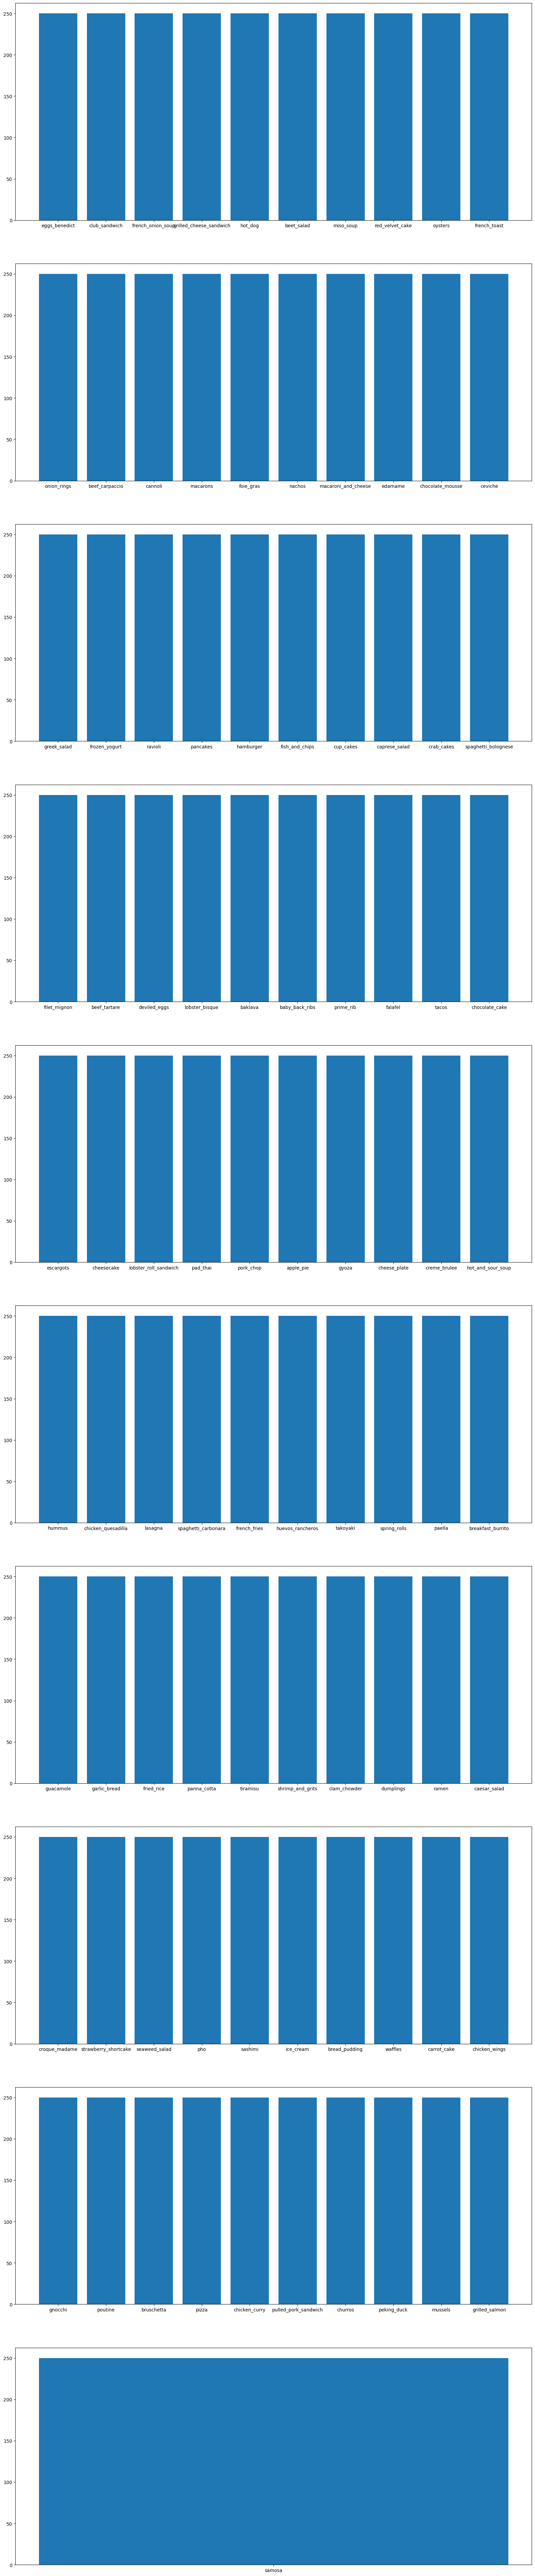

In [10]:
counts_of_classes_visual(df_test)

Как мы видим из графиков количества всех классов одинаково для датасетов, еще раз убедимся в этом, используя метод value_counts

In [11]:
df_train['label'].value_counts()

label
samosa            750
steak             750
pho               750
oysters           750
nachos            750
                 ... 
chocolate_cake    750
ravioli           750
panna_cotta       750
tacos             750
ceviche           750
Name: count, Length: 101, dtype: int64

In [12]:
df_test['label'].value_counts()

label
pancakes         250
falafel          250
miso_soup        250
mussels          250
deviled_eggs     250
                ... 
chicken_curry    250
ceviche          250
cheesecake       250
poutine          250
tiramisu         250
Name: count, Length: 101, dtype: int64

Поскольку количество картинок каждого класса в обоих датасетах равно константе, искать выбросы и исследовать распределение данных, не имеет смысла. 

Далее визуализируем картинки, чтобы посмотреть корректно ли соотносятся картинки с классами

In [13]:
#функция для визуализации изображениий и их классов
def imgs_with_labels_visual(data):
    #задаем размер и количество колонок и строк для графика
    plt.figure(figsize=(20, 15))
    n_cols, n_rows = 8, 5

    #цикл визуализации
    for i in range(1, n_cols * n_rows + 1):
        #t - рандомное значение
        t = np.random.randint(0, data.shape[0] - 1)

        #записываем класс в переменную label и предобрабатывем картинку
        label = data['label'][t]
        img_path = data['path'][t]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #выводим картинку
        ax = plt.subplot(n_rows, n_cols, i)
        ax.imshow(img)
        plt.title(label)
        plt.axis('off')


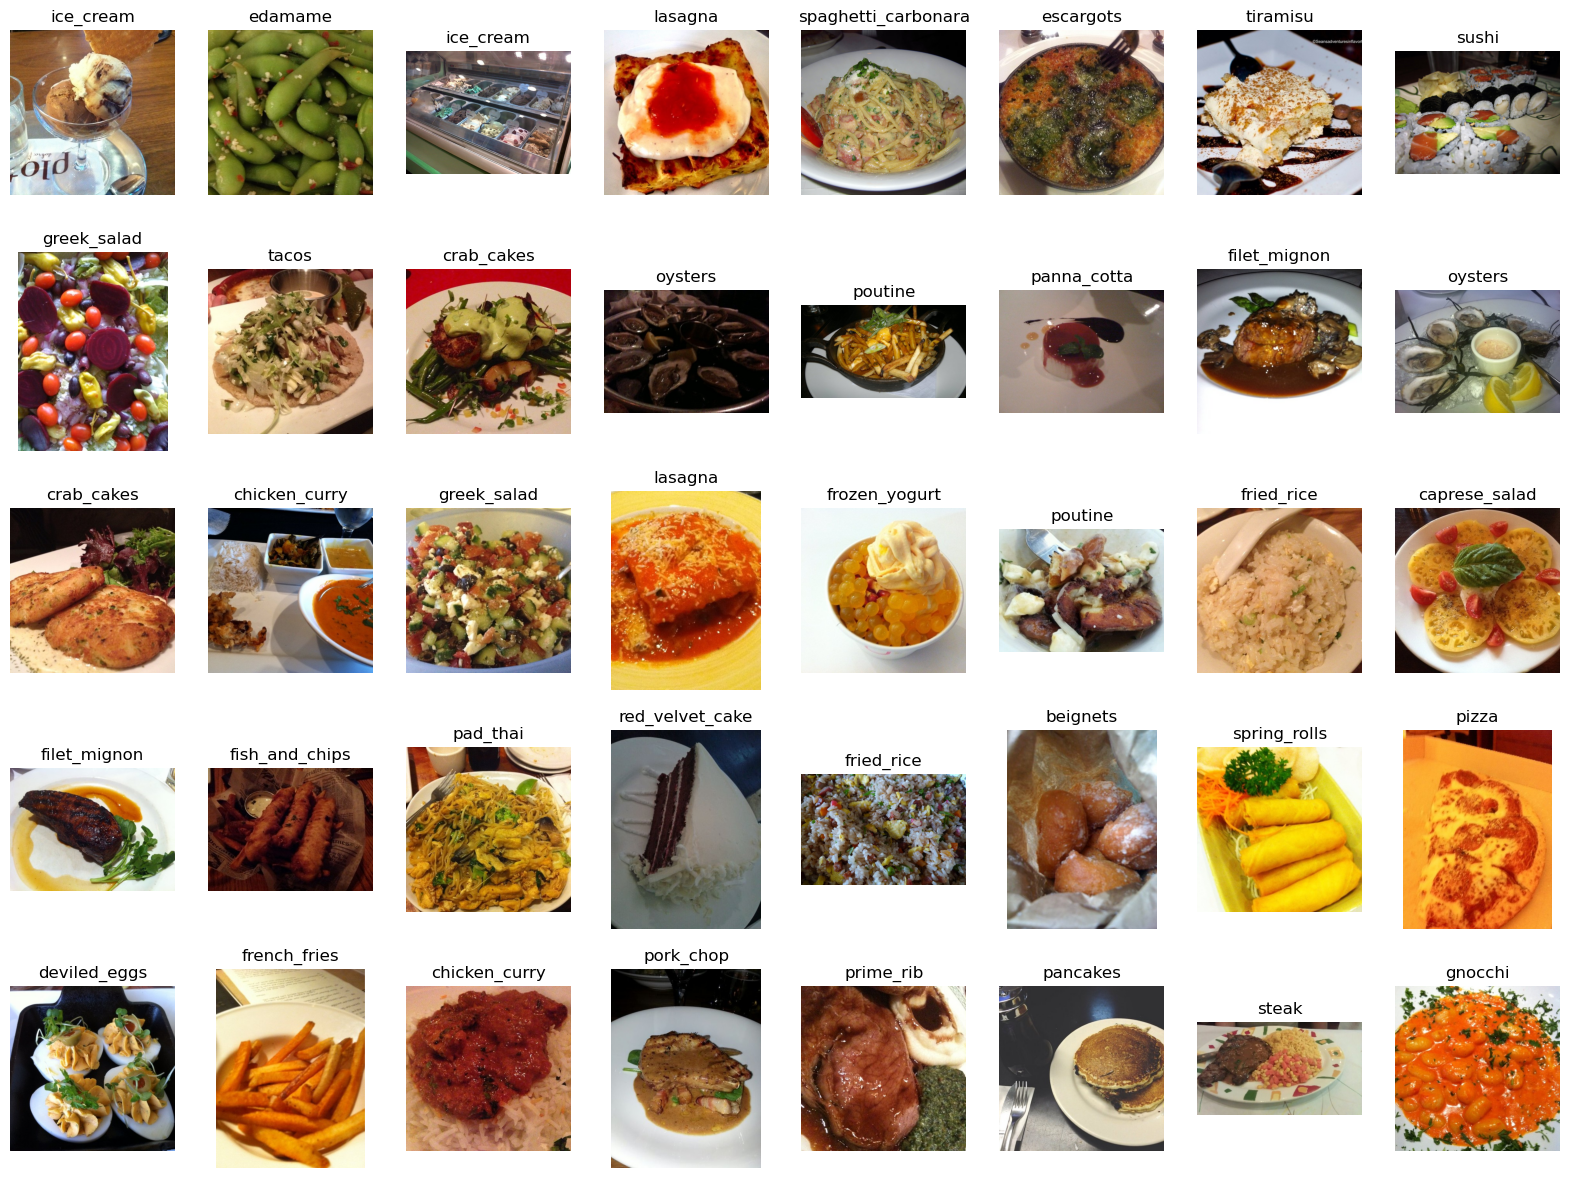

In [14]:
imgs_with_labels_visual(df_train)

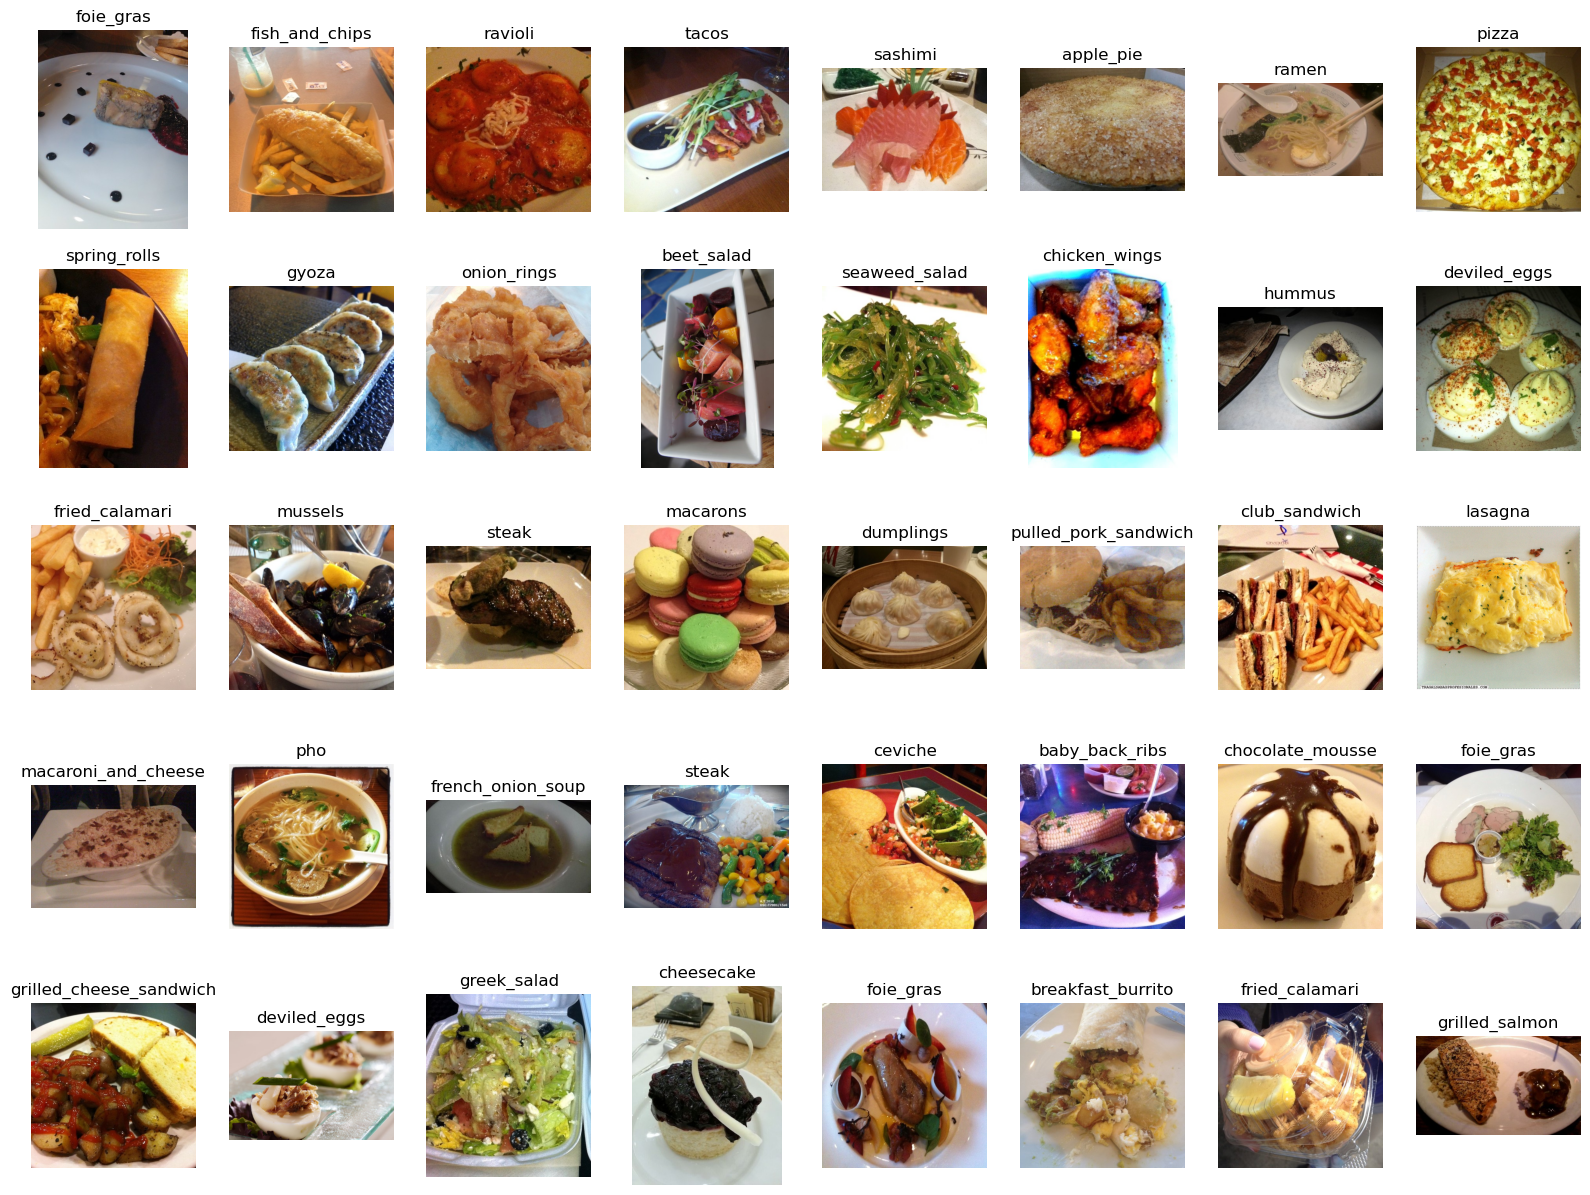

In [15]:
imgs_with_labels_visual(df_test)

Далее проверим датасет на поврежденные изображения

In [16]:
#функция для проверки датасета на поврежденные картинки
def check_damage_img(data):
    for i in tqdm(range(data.shape[0])):
        try:
            img_path = data['path'][i]
            img = cv2.imread(img_path) # проверка на поврежденное изображение
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # проверка на пустой источник
        except:
            print(f'Exception in line {i}') # в случае ошибки выводится данное сообщение


In [17]:
check_damage_img(df_train)

100%|██████████████████████████████████████████████████████████████████| 75750/75750 [02:18<00:00, 547.10it/s]


In [18]:
check_damage_img(df_test)

100%|██████████████████████████████████████████████████████████████████| 25250/25250 [00:46<00:00, 541.20it/s]


Узнаем средние размеры изображений для датасета, это пригодится для выбора архитектуры модели и выбора аугментаций изображений

In [12]:
#Функция для создания датафрема с размерами картинок
def get_df_sizes(data):
    df_sizes = pd.DataFrame()
    heights, widths = [], []
    for img_path in tqdm(data['path']):
        img = cv2.imread(img_path)
        height, width, _ = img.shape
        heights += [height]
        widths += [width]
    df_sizes['height'] = heights
    df_sizes['width'] = widths
    return df_sizes
df_sizes_train = define_sizes_of_images(df_train)
df_sizes_test = define_sizes_of_images(df_test)

100%|██████████████████████████████████████████████████████████████████| 25250/25250 [00:39<00:00, 641.91it/s]


К каждой колонке применяем метод describe

In [8]:
df_sizes_train['height'].describe()

count    75750.000000
mean       475.470548
std         65.344019
min        122.000000
25%        471.000000
50%        512.000000
75%        512.000000
max        512.000000
Name: height, dtype: float64

In [9]:
df_sizes_train['width'].describe()

count    75750.000000
mean       495.780554
std         45.688105
min        193.000000
25%        512.000000
50%        512.000000
75%        512.000000
max        512.000000
Name: width, dtype: float64

In [10]:
df_sizes_test['height'].describe()

count    25250.000000
mean       475.082297
std         65.188707
min        213.000000
25%        395.000000
50%        512.000000
75%        512.000000
max        512.000000
Name: height, dtype: float64

In [11]:
df_sizes_test['width'].describe()

count    25250.000000
mean       495.818495
std         45.640090
min        287.000000
25%        512.000000
50%        512.000000
75%        512.000000
max        512.000000
Name: width, dtype: float64

Из вышеуказанных данных следует, что показатели математического ожидания и среднеквадратического отклонения для обоих выборок почти одинаковые, выраженного дисбаланса между ними нет. Так же можем сделать вывод, что более половины изображений обоих выборок имеют размер 512х512. В более глубоком анализе размеров изображения смысла не вижу.

# 4. Обучение нейронной сети
Перед началом обучения, нужно определиться с архитектурой НС. Задача классификации изображений довольна популярна, так что в интернете много информации и тестов различных архитектур. Одними из лучших для данной задачи являются архитектуры группы EfficientNet и Visual Transofrmer, однако я не могу обучать НС на данных архитектурах, так как мне не хватит вычислительных ресурсов. Так же не плохо себя показывают последние архитектуры моделей ResNet, но они слишком большие и обучаются слишком долго. Я решил остановиться на архитектуре dansenet201, т. к. она имеет оптимальное время обучения и неплохую точность.

Источник - https://habr.com/ru/articles/666314/

Опишем класс датасета, для этого нам нужно определить трансформации изображений. Для тестового датасета используем такие же трансформации как использовались в dansenet201 при обучении, а в тренировочном немного изменяем изображение с помощью случайного поворота, случайного обрезания картинки размером 256х256, случайного отражения по горизонтали.

In [89]:
# тренировочные преобразования изображений
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(256, (0.4, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# тестовые преобразования изображений
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


Определяем класс датасета

In [90]:
class Food101(Dataset):
    def __init__(self, data_frame, transform):
        super().__init__()
        self.images_paths = np.array(data_frame['path']) # полные пути до изображений
        self.images_classes = np.array(data_frame['label']) # классы изображений
        self.transform = transform # определяем трансформации
        # self.classes хранит стабильные значения классов, это сделанно для того, чтобы потом было удобно декодировать информацию
        self.classes = open('/home/misha/Загрузки/food-101/meta/classes.txt').read().split('\n') 

    def __len__(self):
        return len(self.images_classes) # возвращает длину массива классов изображений

    def __getitem__(self, idx):
        img = Image.open(self.images_paths[idx]) # открытие изображения с помощью PIL.Image
        if img.mode != 'RGB':
            img = img.convert('RGB') # Если изображение не RGB, преобразование его в RGB
        img = self.transform(img) # применение всех трансформаций для изображения
        label = self.classes.index(self.images_classes[idx]) # перевод класса изображения в числовое значение (кодирование)
        label = torch.Tensor([label]) # преобразование label в torch.Tensor
        return img, label


Генерируем дата лоадеры для двух наших выборок, тренировочный лоадер перемешиваем, валидационный нет.

In [91]:
train_dataset = Food101(df_train, train_transforms)
test_dataset = Food101(df_test, test_transform)

#тренировочный дата лоадер
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=16,
                                          drop_last=False,
                                          num_workers=16,
                                          shuffle=True)
#валидационный дата лоадер
val_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=16,
                                          drop_last=False,
                                          num_workers=16,
                                          shuffle=False)


Теперь определяем архитектуру нашей нейронной сети. В основе будет лежать предобученная архитектура dansenet201, но нам нужно прописать к ней кастомный классификатор.

In [92]:
class DenseNet201(nn.Module):
    def __init__(self):
        super().__init__()

        # Кастомный классификатор
        classifier = nn.Sequential(nn.Linear(1000, 512, bias=True), 
                                   nn.LeakyReLU(inplace=True),
                                   nn.Linear(512, 101, bias=True),
                                   nn.LeakyReLU(inplace=True))

        # Подгрузка весов предобученной densenet201
        self.model = torchvision.models.densenet201(pretrained=True)

        # Переопределение классификатора
        self.model.fc = classifier

    def forward(self, x):
        out = self.model(x)
        return out


AverageMeter - класс для подсчета метрик

In [93]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


Далее мы определим тренировочный цикл, цикл валидации и функцию predict, которая будет предсказывать класс изображений

In [94]:
# цкил валидации
def val_loop(data_loader, model):
    acc_avg = AverageMeter() # переменная хранящая среднюю точность предсказаний
    for images, labels in tqdm(data_loader):
        batch_size = len(labels) # вычисление размера батча
        labels = labels.view(batch_size) # изменение размерности тензора labels
        label_preds = predict(images, model) # определение нейронной сетью классов изображений
        acc = (labels == label_preds).sum().item() / batch_size # сравнение предсказанных классов с истинными
        acc_avg.update(acc, batch_size)
    print(f'Accuracy: {acc_avg.avg:.5}')
    return acc_avg.avg

# тренировочный цикл
def train_loop(data_loader, model, optimizer, criterion, epoch):
    loss_avg = AverageMeter() # переменная хранящая среднее значение ошибки
    model.train() # перевод модели в тренировочный режим
    for images, labels in tqdm(data_loader):
        optimizer.zero_grad() # обнуление градиентов
        images = images.to('cuda') # закидываем изображения на видеокарту
        labels = labels.type(torch.LongTensor) # изменение типа переменной labels
        batch_size = len(labels) # вычисление размера батча
        labels = labels.view(batch_size) # изменение размерности тензора labels
        labels = labels.to('cuda') # закидываем классы на видеокарту
        out = model(images) # получаем веса нейронной сети
        loss = criterion(out, labels) # вычисляем loss
        loss_avg.update(loss.item(), batch_size)
        loss.backward() # обратное распространение ошибки
        optimizer.step() # шаг оптимизатора
    for params in optimizer.param_groups:
        lr = params['lr'] 
        # узнаем learning rate (изначально предпологалось, что я буду использовать lr_scheduler, 
        # но в конечном варианте я его не использовал)
    print(f'\nEpoch: {epoch}, Loss: {loss_avg.avg:.5}, lr: {lr:.7}') # вывод информации
    return loss_avg.avg

# функция предсказания
def predict(images, model):
    model.eval() # перевод модели в режим вычислений
    images = images.to('cuda') # закидываем изображения на видеокарту
    with torch.no_grad(): # отключение вычисления градиента 
        out = model(images) # вычисление весов НС
    out = nn.functional.softmax(out, dim=1) # применяем к выходу НС функцию softmax
    preds = torch.argmax(out.detach().cpu(), -1).numpy() # узнаем номер нейрона с максимальным значением
    return torch.Tensor(preds)


Далее создаем функцию обучения. Я не вычисляю точность у тренировочной выборки, т. к. это занимает много времени. В следующих частях обучения я посчитаю его отдельно для некоторых эпох, чтобы увидеть как протекало обучение

In [95]:
def train(train_loader, val_loader, _optimizer, save_dir, epochs, _scheduler=None, weights_dir=None):
    os.makedirs(save_dir, exist_ok=True) # директория для сохранения результатов
    model = DenseNet201() # определяем архитектуру НС
    model.to('cuda') # перебрасываем модель на видеокарту
    if weights_dir: # если дообучиваем модель с чекпоинта
        model.load_state_dict(torch.load(weights_dir)) # загружаем веса модели
        acc_val_avg = val_loop(val_loader, model) # вычисляем точность предсказаний на основе валидационной выборки
    criterion = torch.nn.CrossEntropyLoss() # в качестве функции потерь берем стандартную для классификации кроссэнтропию
    optimizer = _optimizer(model.parameters(), lr = 0.0001, weight_decay=0.01) # определяем гиперпараметры для оптимизатора
    if _scheduler: # если используем lr_scheduler
        scheduler = _scheduler(optimizer=optimizer, mode='max', factor=0.25, patience=5) # определяем lr_scheduler
    if len(os.listdir(save_dir)) != 0: # определение директории для сохранения чекпоинтов и таблицы с метриками
        num = max(list(map(int, os.listdir(save_dir)))) + 1
    else:
        num = 1
    path = f'{save_dir}/{num}' # путь до директории сохранения
    os.makedirs(path) # создание директории
    os.makedirs(f'{path}/checkpoints') # создание папки checkpoints для сохранения чекпоинтов каждой эпохи
    file = open(f'{path}/metrcis.tsv', 'a+') # создание таблицы с метриками
    file.write('epoch\tloss\taccuracy_validation\tlr\n') # запись названия столбцов
    for epoch in range(epochs): # цикл обучения
        loss_avg = train_loop(train_loader, model, optimizer, criterion, epoch) # вычисление loss для тренировочной выборки
        acc_val_avg = val_loop(val_loader, model) # вычисление точности для валидационной выборки
        for params in optimizer.param_groups:
            lr = params['lr'] # определение learning rate
        if _scheduler:
            scheduler.step(loss_avg) # шаг lr_scheduler'a
        file = open(f'{path}/metrcis.tsv', 'a+')
        file.write(f'{epoch}\t{loss_avg}\t{acc_val_avg}\t{lr}\n') # запись новой строчки в таблицу
        file.close()
        model_save_path = f'{path}/checkpoints/model_epoch{epoch}.ckpt' 
        torch.save(model.state_dict(), model_save_path) # сохранение весов для каждой эпохи
        print('Model weights saved')


Для первого цикла обучения, воспользуемся оптимизатором Adam с дефолтным lr=0.001 и не будем пользоваться lr_schedulr'ом, т. к. как показали предыдущие циклы обучения эффективнее будет самомоу поменять lr при выходе метрик на плато. Конечно можно было бы тонко настроить lr_scheduler.ReduceLROnPlateau, но мне проще самому изменить lr.

In [11]:
train(train_loader, val_loader, torch.optim.Adam, '/home/misha/Food101_models', 50)

/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:19<00:00,  4.55it/s]



Epoch: 0, Loss: 4.2416, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:31<00:00, 17.33it/s]


Validation, accuracy: 0.13576
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:17<00:00,  4.57it/s]



Epoch: 1, Loss: 3.5202, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.41it/s]


Validation, accuracy: 0.18764
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:19<00:00,  4.55it/s]



Epoch: 2, Loss: 3.0065, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.36it/s]


Validation, accuracy: 0.31648
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:14<00:00,  4.58it/s]



Epoch: 3, Loss: 2.6083, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.47it/s]


Validation, accuracy: 0.38099
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:11<00:00,  4.59it/s]



Epoch: 4, Loss: 2.323, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.51it/s]


Validation, accuracy: 0.41814
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:10<00:00,  4.59it/s]



Epoch: 5, Loss: 2.12, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.51it/s]


Validation, accuracy: 0.4638
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:10<00:00,  4.60it/s]



Epoch: 6, Loss: 1.9427, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.47it/s]


Validation, accuracy: 0.48661
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:12<00:00,  4.59it/s]



Epoch: 7, Loss: 1.8104, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.91it/s]


Validation, accuracy: 0.51077
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:20<00:00,  4.55it/s]



Epoch: 8, Loss: 1.6997, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.85it/s]


Validation, accuracy: 0.52008
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:22<00:00,  4.54it/s]



Epoch: 9, Loss: 1.6061, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.89it/s]


Validation, accuracy: 0.54416
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:19<00:00,  4.56it/s]



Epoch: 10, Loss: 1.5368, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.88it/s]


Validation, accuracy: 0.56958
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:20<00:00,  4.55it/s]



Epoch: 11, Loss: 1.4624, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.91it/s]


Validation, accuracy: 0.56899
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:19<00:00,  4.56it/s]



Epoch: 12, Loss: 1.4148, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.88it/s]


Validation, accuracy: 0.57089
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:18<00:00,  4.56it/s]



Epoch: 13, Loss: 1.3579, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.91it/s]


Validation, accuracy: 0.57857
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:18<00:00,  4.56it/s]



Epoch: 14, Loss: 1.3142, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.88it/s]


Validation, accuracy: 0.58059
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:22<00:00,  4.54it/s]



Epoch: 15, Loss: 1.2641, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:34<00:00, 16.63it/s]


Validation, accuracy: 0.59164
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:22<00:00,  4.54it/s]



Epoch: 16, Loss: 1.2257, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:34<00:00, 16.70it/s]


Validation, accuracy: 0.59358
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:22<00:00,  4.54it/s]



Epoch: 17, Loss: 1.1864, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:34<00:00, 16.68it/s]


Validation, accuracy: 0.60404
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:25<00:00,  4.53it/s]



Epoch: 18, Loss: 1.1572, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:35<00:00, 16.47it/s]


Validation, accuracy: 0.59826
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:25<00:00,  4.53it/s]



Epoch: 19, Loss: 1.1219, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:36<00:00, 16.36it/s]


Validation, accuracy: 0.60851
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:34<00:00,  4.49it/s]



Epoch: 20, Loss: 1.1023, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.18it/s]


Validation, accuracy: 0.61552
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:33<00:00,  4.50it/s]



Epoch: 21, Loss: 1.0673, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.22it/s]


Validation, accuracy: 0.61461
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:33<00:00,  4.50it/s]



Epoch: 22, Loss: 1.0406, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.24it/s]


Validation, accuracy: 0.61616
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:35<00:00,  4.49it/s]



Epoch: 23, Loss: 1.0151, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.18it/s]


Validation, accuracy: 0.61952
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:20<00:00,  4.55it/s]



Epoch: 24, Loss: 0.98378, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.86it/s]


Validation, accuracy: 0.62186
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:17<00:00,  4.56it/s]



Epoch: 25, Loss: 0.96139, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.94it/s]


Validation, accuracy: 0.62337
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:15<00:00,  4.57it/s]



Epoch: 26, Loss: 0.94474, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:32<00:00, 16.99it/s]


Validation, accuracy: 0.63279
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:17<00:00,  4.57it/s]



Epoch: 27, Loss: 0.91965, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:32<00:00, 17.01it/s]


Validation, accuracy: 0.62479
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:21<00:00,  4.55it/s]



Epoch: 28, Loss: 0.90103, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:35<00:00, 16.55it/s]


Validation, accuracy: 0.63339
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:27<00:00,  4.52it/s]



Epoch: 29, Loss: 0.87733, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:33<00:00, 16.84it/s]


Validation, accuracy: 0.63002
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:24<00:00,  4.53it/s]



Epoch: 30, Loss: 0.85635, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:35<00:00, 16.51it/s]


Validation, accuracy: 0.63125
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:21<00:00,  4.55it/s]



Epoch: 31, Loss: 0.8416, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:34<00:00, 16.73it/s]


Validation, accuracy: 0.62962
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:26<00:00,  4.52it/s]



Epoch: 32, Loss: 0.82603, lr: 0.001


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.17it/s]


Validation, accuracy: 0.63251
Model weights saved


  1%|▋                                                                      | 47/4735 [00:11<18:40,  4.18it/s]


KeyboardInterrupt: 

Определим функцию для вычисления loss для валидационной выборки, она будет аналогична функции train_loop, за исключением того, что модель переведена в режим вычислений и выключенно вычисление градиентов при вычислении модели

In [21]:
def get_loss_val(criterion, model, data_loader):
    loss_avg = AverageMeter()
    model.eval()
    for images, labels in tqdm(data_loader):
        images = images.to('cuda')
        batch_size = len(labels)
        labels = labels.type(torch.LongTensor)
        labels = labels.view(batch_size)
        labels = labels.to('cuda')
        with torch.no_grad():
            out = model(images)
        loss = criterion(out, labels)
        loss_avg.update(loss.item(), batch_size)
    print(f'Validation Loss - {loss_avg.avg:.5}')
    return loss_avg.avg

Посчитаем валидационный loss и тренирочную точность для последних 8 эпох, также достанем из таблицы тренировочный loss и валидационную точность и нарисуем график, для визуализации обучения

In [42]:
model = DenseNet201() # инициализируем архитектуру модели
model.to('cuda')
loss_fn = torch.nn.CrossEntropyLoss()
metrics = open('/home/misha/Food101_models/38/metrics.tsv').read().split('\n') 
# инициализируем списки с метриками
validation_accuracys, validation_losses, train_accuracys, train_losses = [], [], [], []
for i in range(25, 33): # цикл для вычисления метрик
    weights_dir = f'/home/misha/Food101_models/38/checkpoints/model_epoch{i}.ckpt'
    model.load_state_dict(torch.load(weights_dir)) # подгружаем веса НС
    val_acc = np.float32(metrics[i + 1].split('\t')[2]) # Берем точность валидационной выборки из таблицы
    train_loss = np.float32(metrics[i + 1].split('\t')[1]) # Берем loss тренировочной выборки из таблицы
    val_loss = get_loss_val(loss_fn, model, val_loader) # Вычисляем loss валидационной выборки
    train_acc = val_loop(train_loader, model) # Вычисляем точность тренировочной выборки
    # Распределяем метрики по массивам
    validation_accuracys += [val_acc] 
    validation_losses += [val_loss]
    train_accuracys += [train_acc]
    train_losses += [train_loss]

100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.90it/s]


Validation Loss - 1.0415


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:25<00:00, 14.53it/s]


Accuracy: 0.66077


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.79it/s]


Validation Loss - 1.0196


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:25<00:00, 14.54it/s]


Accuracy: 0.67362


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.78it/s]


Validation Loss - 1.0129


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:26<00:00, 14.51it/s]


Accuracy: 0.67134


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.83it/s]


Validation Loss - 1.0047


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:25<00:00, 14.54it/s]


Accuracy: 0.68401


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.81it/s]


Validation Loss - 1.0732


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:25<00:00, 14.55it/s]


Accuracy: 0.68451


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.83it/s]


Validation Loss - 1.025


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:25<00:00, 14.56it/s]


Accuracy: 0.6882


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.80it/s]


Validation Loss - 1.0496


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:25<00:00, 14.56it/s]


Accuracy: 0.68661


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.77it/s]


Validation Loss - 1.0191


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:25<00:00, 14.53it/s]

Accuracy: 0.69537


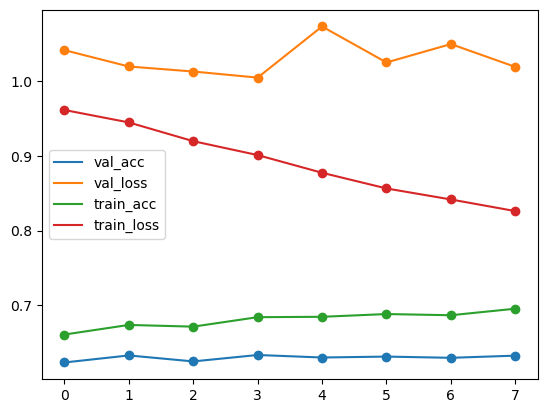

In [43]:
# Отображаем график
plt.scatter(np.arange(8), validation_accuracys)
plt.plot(np.arange(8), validation_accuracys, label='val_acc')
plt.scatter(np.arange(8), validation_losses)
plt.plot(np.arange(8), validation_losses, label='val_loss')
plt.scatter(np.arange(8), train_accuracys)
plt.plot(np.arange(8), train_accuracys, label='train_acc')
plt.scatter(np.arange(8), train_losses)
plt.plot(np.arange(8), train_losses, label='train_loss')
plt.legend()

Как мы видим из графика метрики accuracy вышли на плато и изменяются слабо, так же мы видим, что графики loss'ов начали расходится, что может сведельствовать о скором переобучении. Итак дообучим нашу НС на основе этих весов, с помощью оптимизатора AdamW с параметрами lr=0.00025, weights_decay = 0.05 

In [15]:
weights_dir = '/home/misha/Food101_models/38/checkpoints/model_epoch32.ckpt'
train(train_loader, val_loader, torch.optim.AdamW, '/home/misha/Food101_models', 25, weights_dir=weights_dir)

/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.20it/s]


Validation, accuracy: 0.63251


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:32<00:00,  4.50it/s]



Epoch: 0, Loss: 0.635, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.19it/s]


Validation, accuracy: 0.65501
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:30<00:00,  4.51it/s]



Epoch: 1, Loss: 0.60099, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.22it/s]


Validation, accuracy: 0.6522
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:31<00:00,  4.50it/s]



Epoch: 2, Loss: 0.59241, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.24it/s]


Validation, accuracy: 0.65588
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:31<00:00,  4.50it/s]



Epoch: 3, Loss: 0.58903, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.18it/s]


Validation, accuracy: 0.66004
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:31<00:00,  4.51it/s]



Epoch: 4, Loss: 0.58363, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.23it/s]


Validation, accuracy: 0.65861
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:31<00:00,  4.50it/s]



Epoch: 5, Loss: 0.58446, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.23it/s]


Validation, accuracy: 0.65865
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:31<00:00,  4.50it/s]



Epoch: 6, Loss: 0.58752, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.24it/s]


Validation, accuracy: 0.66178
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:30<00:00,  4.51it/s]



Epoch: 7, Loss: 0.59175, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.24it/s]


Validation, accuracy: 0.66242
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:30<00:00,  4.51it/s]



Epoch: 8, Loss: 0.59027, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:37<00:00, 16.22it/s]


Validation, accuracy: 0.66257
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:25<00:00,  4.53it/s]



Epoch: 9, Loss: 0.59512, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:31<00:00, 17.34it/s]


Validation, accuracy: 0.66622
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:09<00:00,  4.60it/s]



Epoch: 10, Loss: 0.5987, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.38it/s]


Validation, accuracy: 0.66345
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:09<00:00,  4.60it/s]



Epoch: 11, Loss: 0.60638, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.38it/s]


Validation, accuracy: 0.66352
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:09<00:00,  4.60it/s]



Epoch: 12, Loss: 0.6021, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.38it/s]


Validation, accuracy: 0.66531
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:09<00:00,  4.60it/s]



Epoch: 13, Loss: 0.61027, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.39it/s]


Validation, accuracy: 0.66261
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:09<00:00,  4.60it/s]



Epoch: 14, Loss: 0.61812, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.40it/s]


Validation, accuracy: 0.66317
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:09<00:00,  4.60it/s]



Epoch: 15, Loss: 0.62504, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.40it/s]


Validation, accuracy: 0.65909
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:09<00:00,  4.60it/s]



Epoch: 16, Loss: 0.62626, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.38it/s]


Validation, accuracy: 0.66638
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:10<00:00,  4.60it/s]



Epoch: 17, Loss: 0.63118, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:31<00:00, 17.35it/s]


Validation, accuracy: 0.66392
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:10<00:00,  4.59it/s]



Epoch: 18, Loss: 0.64239, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.35it/s]


Validation, accuracy: 0.66578
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:10<00:00,  4.60it/s]



Epoch: 19, Loss: 0.65099, lr: 0.00025


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:30<00:00, 17.36it/s]


Validation, accuracy: 0.66499
Model weights saved


 85%|██████████████████████████████████████████████████████████▍          | 4007/4735 [14:34<02:38,  4.58it/s]


KeyboardInterrupt: 

Видно, что НС наилучшим образом показывает себя на первых 5 эпохах, возьмем их и визуализируем обучение по аналогии с предыдущим циклом обучения.

In [50]:
model = DenseNet201()
model.to('cuda')
loss_fn = torch.nn.CrossEntropyLoss()
metrics = open('/home/misha/Food101_models/39/metrics.tsv').read().split('\n')
for i in range(5):
    weights_dir = f'/home/misha/Food101_models/39/checkpoints/model_epoch{i}.ckpt'
    model.load_state_dict(torch.load(weights_dir))
    val_acc = np.float32(metrics[i + 1].split('\t')[2])
    train_loss = np.float32(metrics[i + 1].split('\t')[1])
    val_loss = get_loss_val(loss_fn, model, val_loader)
    train_acc = val_loop(train_loader, model)
    validation_accuracys += [val_acc]
    validation_losses += [val_loss]
    train_accuracys += [train_acc]
    train_losses += [train_loss]

/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.90it/s]


Validation Loss - 0.90488


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:26<00:00, 14.50it/s]


Accuracy: 0.73211


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.81it/s]


Validation Loss - 0.88983


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:26<00:00, 14.49it/s]


Accuracy: 0.73106


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.78it/s]


Validation Loss - 0.87867


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:27<00:00, 14.47it/s]


Accuracy: 0.7395


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.78it/s]


Validation Loss - 0.87896


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:26<00:00, 14.50it/s]


Accuracy: 0.7444


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.82it/s]


Validation Loss - 0.86885


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:26<00:00, 14.51it/s]

Accuracy: 0.74545


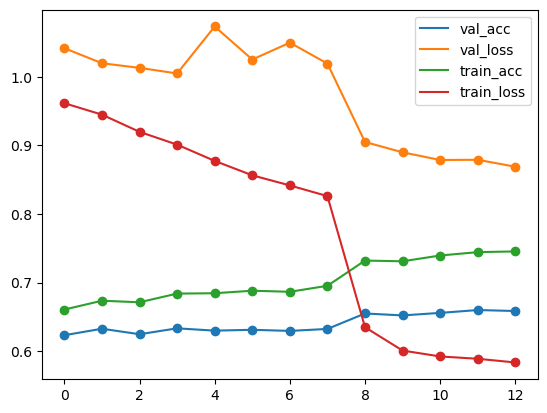

In [51]:
plt.scatter(np.arange(13), validation_accuracys)
plt.plot(np.arange(13), validation_accuracys, label='val_acc')
plt.scatter(np.arange(13), validation_losses)
plt.plot(np.arange(13), validation_losses, label='val_loss')
plt.scatter(np.arange(13), train_accuracys)
plt.plot(np.arange(13), train_accuracys, label='train_acc')
plt.scatter(np.arange(13), train_losses)
plt.plot(np.arange(13), train_losses, label='train_loss')
plt.legend()

Неплохой результат loss упал значительно, метрики accuracy поднялись, расхождения loss'ов нет. Попробуем еще уменьшить lr и дообучить модель

In [13]:
weights_dir = '/home/misha/Food101_models/39/checkpoints/model_epoch4.ckpt'
train(train_loader, val_loader, torch.optim.AdamW, '/home/misha/Food101_models', 10, weights_dir=weights_dir)

100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:29<00:00, 17.60it/s]


Validation, accuracy: 0.66214


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:46<00:00,  4.44it/s]



Epoch: 0, Loss: 0.53308, lr: 5e-05


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:40<00:00, 15.67it/s]


Validation, accuracy: 0.6636
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [18:11<00:00,  4.34it/s]



Epoch: 1, Loss: 0.52768, lr: 5e-05


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:34<00:00, 16.68it/s]


Validation, accuracy: 0.6655
Model weights saved


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [17:47<00:00,  4.44it/s]



Epoch: 2, Loss: 0.52565, lr: 5e-05


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:38<00:00, 16.05it/s]


Validation, accuracy: 0.66709
Model weights saved


 25%|█████████████████▏                                                   | 1176/4735 [04:31<13:41,  4.33it/s]


KeyboardInterrupt: 

Видно, что нейронная сеть практически не обучается и хоть и loss упал по сравнению с предыдущим циклом обучения, особого смысла обучать НС до конца нету, это не сильно поднимет точность нашей НС. Так же визуализируем ход обучения

In [52]:
model = DenseNet201()
model.to('cuda')
loss_fn = torch.nn.CrossEntropyLoss()
metrics = open('/home/misha/Food101_models/40/metrics.tsv').read().split('\n')
for i in range(3):
    weights_dir = f'/home/misha/Food101_models/40/checkpoints/model_epoch{i}.ckpt'
    model.load_state_dict(torch.load(weights_dir))
    val_acc = np.float32(metrics[i + 1].split('\t')[2])
    train_loss = np.float32(metrics[i + 1].split('\t')[1])
    val_loss = get_loss_val(loss_fn, model, val_loader)
    train_acc = val_loop(train_loader, model)
    validation_accuracys += [val_acc]
    validation_losses += [val_loss]
    train_accuracys += [train_acc]
    train_losses += [train_loss]

100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.81it/s]


Validation Loss - 0.827


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:26<00:00, 14.52it/s]


Accuracy: 0.75174


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.77it/s]


Validation Loss - 0.83034


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:25<00:00, 14.54it/s]


Accuracy: 0.75493


100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:28<00:00, 17.79it/s]


Validation Loss - 0.81492


100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:26<00:00, 14.50it/s]

Accuracy: 0.7586


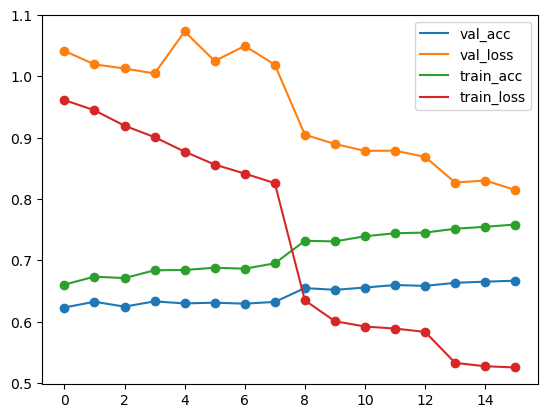

In [53]:
plt.scatter(np.arange(16), validation_accuracys)
plt.plot(np.arange(16), validation_accuracys, label='val_acc')
plt.scatter(np.arange(16), validation_losses)
plt.plot(np.arange(16), validation_losses, label='val_loss')
plt.scatter(np.arange(16), train_accuracys)
plt.plot(np.arange(16), train_accuracys, label='train_acc')
plt.scatter(np.arange(16), train_losses)
plt.plot(np.arange(16), train_losses, label='train_loss')
plt.legend()

Я думаю, на достигнтом результате стоит остановиться, можно попробывать еще по перебирать гиперпараметы, но скорее всего значительных изменений не будет.

# 5. Анализ полученных результатов

Посмотрим на процент правильнных классификаций в каждом классе. Для этого я написал функцию special_loop, которая возвращает словарь с ключем - классом изображения и значением массивом. в этом массиве под нулевым индеком хранится процент правильно отклассифицированных изображений, а под первым индеком хранится массив с классами, которые чаще всего были ложно классифицированы. 

In [65]:
def special_loop(data_loader, model, k):
    classes_acc_dict = {}
    classes_names = open('/home/misha/Загрузки/food-101/meta/labels.txt').read().split('\n')
    for images, labels in tqdm(data_loader):
        batch_size = len(labels)
        labels = labels.view(batch_size)
        label_preds = predict(images, model)
        for y_true, y_pred in zip(labels, label_preds):
            key = classes_names[np.int8(y_true.item())]
            if key not in classes_acc_dict:
                classes_acc_dict[key] = [0, []]
            if y_true == y_pred:
                classes_acc_dict[key][0] += k
            else:
                key_pred = classes_names[np.int16(y_pred.item()) % 101]
                wrong_classes = [el[0] for el in classes_acc_dict[key][1]]
                if key_pred not in wrong_classes:
                    classes_acc_dict[key][1] += [[key_pred, 1]]
                else:
                    idx = wrong_classes.index(key_pred)
                    classes_acc_dict[key][1][idx][1] += 1
    for key in classes_acc_dict:
        classes_acc_dict[key][1] = sorted(classes_acc_dict[key][1], key=lambda x: x[1], reverse=True)
    return classes_acc_dict


In [66]:
weights_dir = '/home/misha/Food101_models/40/checkpoints/model_epoch2.ckpt'
model = DenseNet201()
model.to('cuda')
model.load_state_dict(torch.load(weights_dir))
val_dict = special_loop(val_loader, model, 0.004)
val_dict

/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████| 1579/1579 [01:34<00:00, 16.75it/s]


{'Ice cream': [0.4240000000000003,
  [['Frozen yogurt', 28],
   ['Macarons', 8],
   ['Chocolate mousse', 8],
   ['Bread pudding', 7],
   ['Panna cotta', 6],
   ['Cup cakes', 4],
   ['Chocolate cake', 4],
   ['Strawberry shortcake', 4],
   ['Fried calamari', 3],
   ['Tiramisu', 3],
   ['Carrot cake', 3],
   ['Greek salad', 3],
   ['Prime rib', 3],
   ['Oysters', 3],
   ['Onion rings', 3],
   ['Nachos', 2],
   ['Croque madame', 2],
   ['Cannoli', 2],
   ['Risotto', 2],
   ['Takoyaki', 2],
   ['Cheese plate', 2],
   ['Apple pie', 2],
   ['Dumplings', 2],
   ['Churros', 2],
   ['French fries', 2],
   ['Pho', 2],
   ['Baby back ribs', 2],
   ['Waffles', 2],
   ['Caesar salad', 2],
   ['Edamame', 1],
   ['Baklava', 1],
   ['Hot and sour soup', 1],
   ['Bibimbap', 1],
   ['Chicken quesadilla', 1],
   ['Beignets', 1],
   ['Clam chowder', 1],
   ['Deviled eggs', 1],
   ['Red velvet cake', 1],
   ['Caprese salad', 1],
   ['Hot dog', 1],
   ['Sashimi', 1],
   ['Donuts', 1],
   ['Fish and chips', 

Визуализируем данную информацию с помощью функции visual_dict

In [69]:
def visual_dict(dict, n):
    plt.figure(figsize = (20, 70))
    n_rows, n_cols = 11, 1
    for i, key in enumerate(dict):
        if i % 10 == 0:
            ax = plt.subplot(n_rows, n_cols, i // 10 + 1)
            keys = []
        ax.bar(x=i%10, height=dict[key][0], width=0.25),
        ax.bar(x=i%10-0.25, height=dict[key][1][0][1] / n, width=0.25, label=dict[key][1][0][0])
        keys += [key]
        if i % 10 == 9:
            ax.legend(loc='upper left')
            ax.set_xticks(np.arange(10) - 0.125, keys)
        if i == 100:
            ax.legend(loc='upper left')
            ax.set_xlabel(key, loc='center')

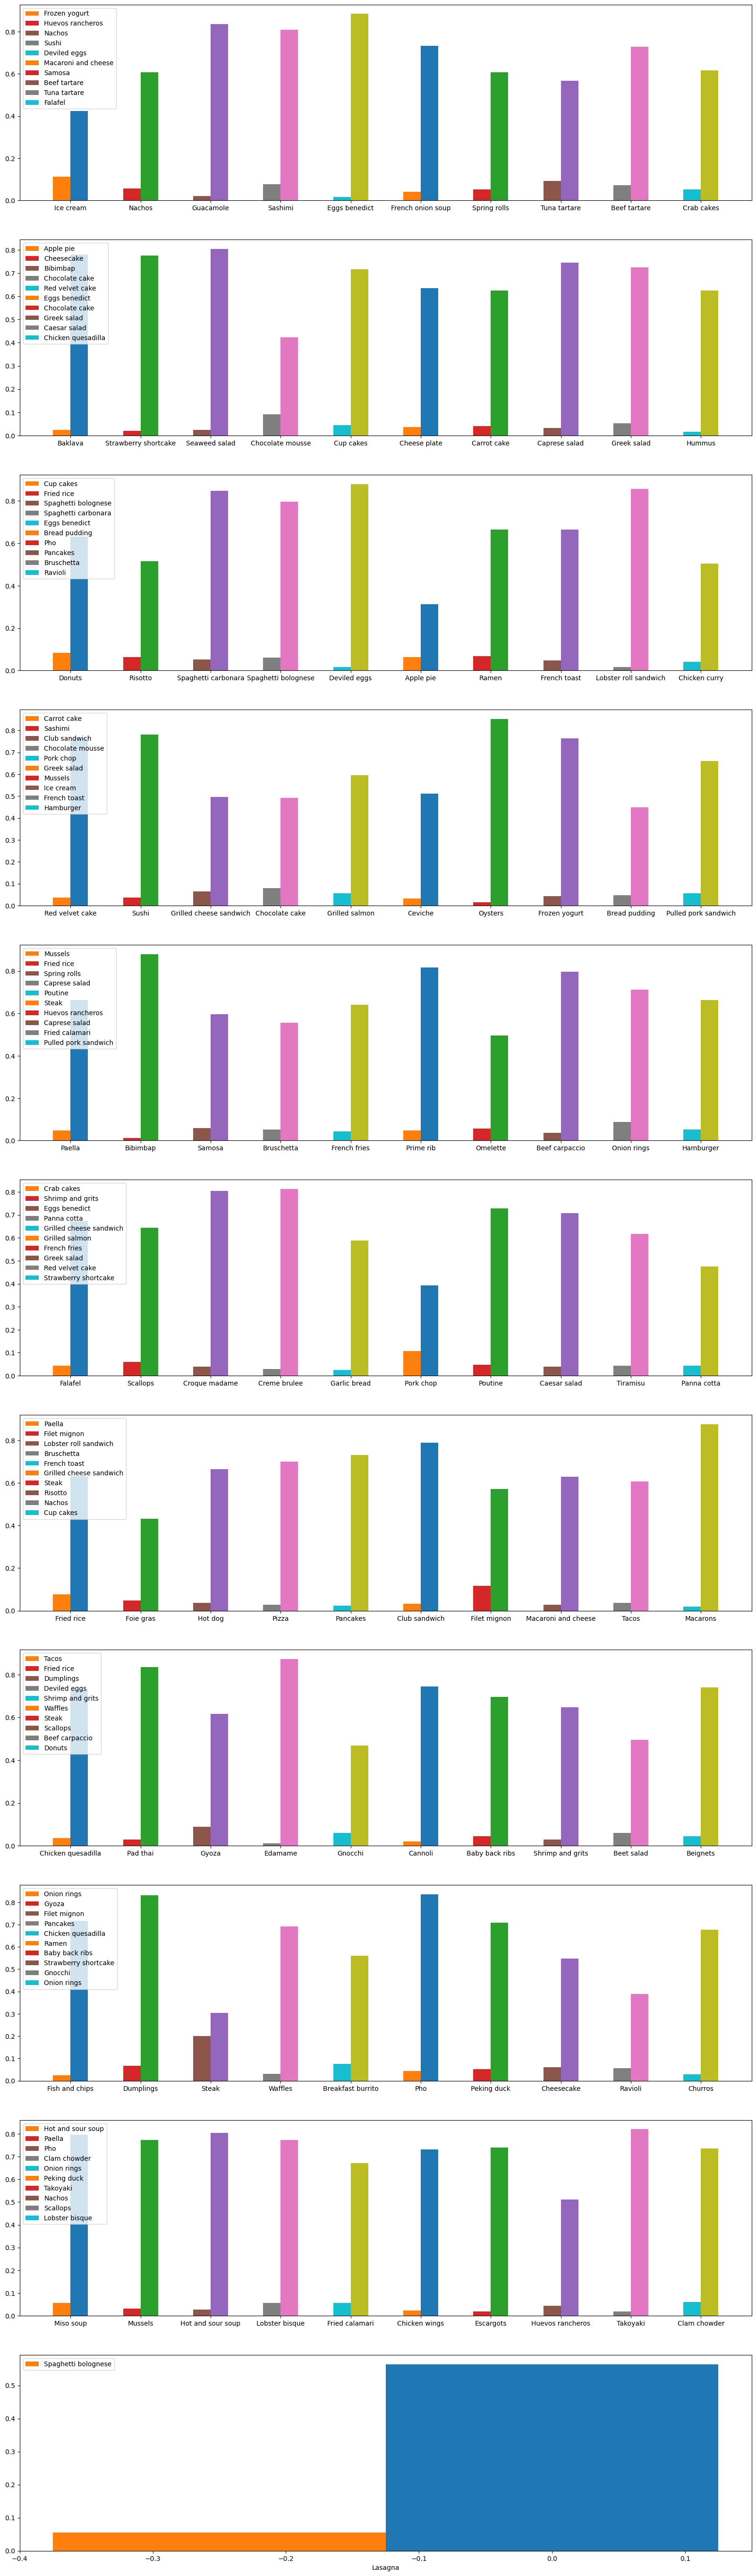

In [70]:
visual_dict(val_dict, 250)

Тоже самое проделаем для тренировочной выборки

In [71]:
train_dict = special_loop(train_loader, model, 1/750)
train_dict

/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/misha/anaconda3/envs/NN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████| 4735/4735 [05:39<00:00, 13.94it/s]


{'Prime rib': [0.8226666666666611,
  [['Baby back ribs', 20],
   ['Filet mignon', 19],
   ['Steak', 16],
   ['Pork chop', 7],
   ['Chocolate cake', 5],
   ['Macarons', 5],
   ['Beef carpaccio', 4],
   ['Chicken wings', 4],
   ['French onion soup', 3],
   ['Chicken curry', 3],
   ['Ramen', 3],
   ['Seaweed salad', 2],
   ['Bread pudding', 2],
   ['Oysters', 2],
   ['French toast', 2],
   ['Tiramisu', 2],
   ['Peking duck', 2],
   ['Paella', 2],
   ['Foie gras', 2],
   ['Hamburger', 2],
   ['Poutine', 2],
   ['Churros', 2],
   ['Grilled salmon', 2],
   ['Cup cakes', 2],
   ['Pulled pork sandwich', 2],
   ['Crab cakes', 1],
   ['Hot dog', 1],
   ['Eggs benedict', 1],
   ['Nachos', 1],
   ['Ice cream', 1],
   ['Lobster roll sandwich', 1],
   ['French fries', 1],
   ['Creme brulee', 1],
   ['Takoyaki', 1],
   ['Deviled eggs', 1],
   ['Escargots', 1],
   ['Grilled cheese sandwich', 1],
   ['Chicken quesadilla', 1],
   ['Pho', 1],
   ['Red velvet cake', 1],
   ['Cannoli', 1]]],
 'Peking duck'

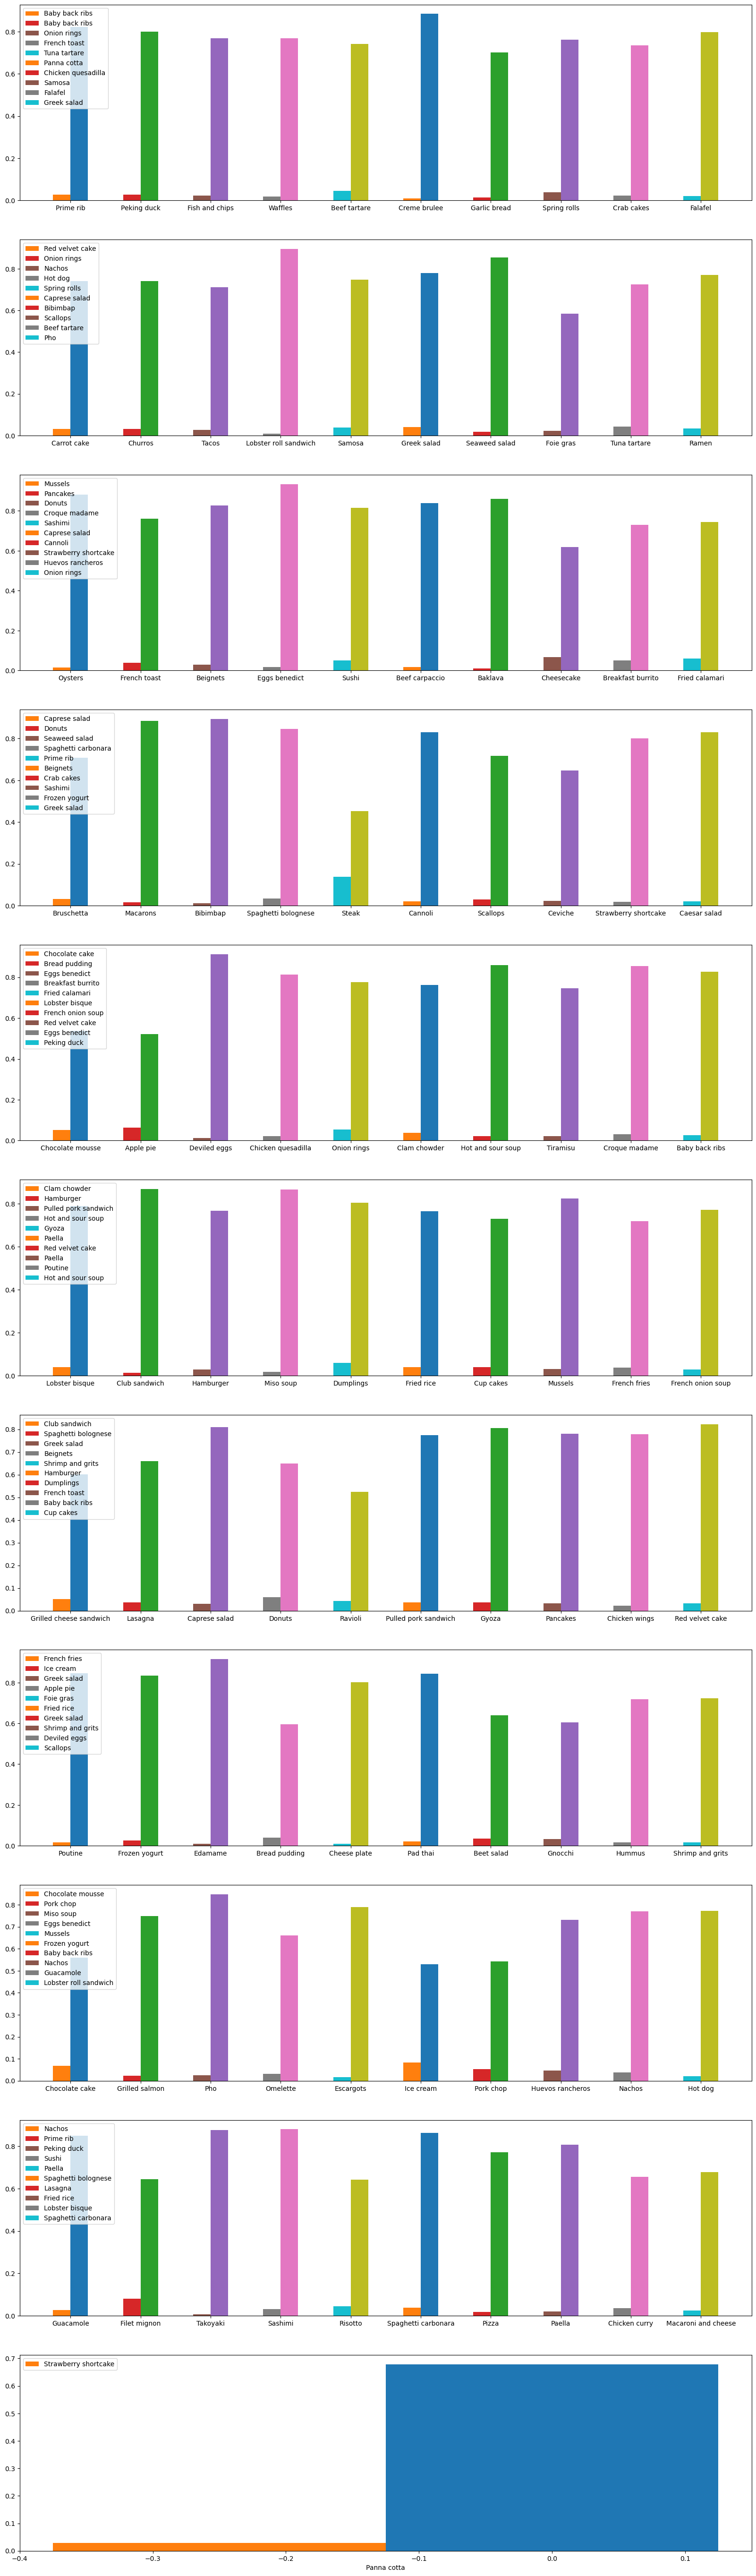

In [72]:
visual_dict(train_dict, 750)

Из этих данных видно, что действительно некоторый дисбаланс есть. Например класс steak очень часто классифицируется как Filet mignon или Apple pie часто классифицируется как Bread pudding. В качестве решения данной проблемы можно удалить один из двух схожих классов или объединить их в один более обобщающий класс, либо если нам критически важно различать оба класса, можно попробывать расширить выборку изображений путем аугментаций. Это может улучшить устойчивость модели. Аугментации могут быть различные, например: поворот изображения, отражение, перемешивание цветовых каналов, изменение яркости, контрастности.

Давайте опробуем нашу модель на картинках из интернета

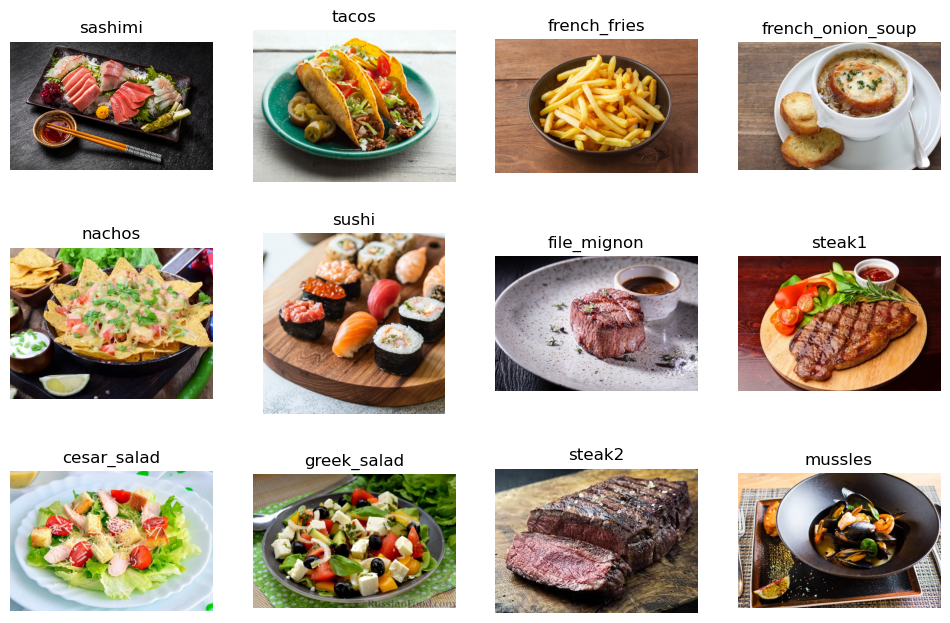

In [84]:
path = '/home/misha/Загрузки/test_food/'
n_rows, n_cols = 3, 4
plt.figure(figsize=(12, 8))
test_imgs_names = os.listdir(path)
for i, img_name in enumerate(test_imgs_names):
    full_path = path + img_name
    img = cv2.imread(full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(n_rows, n_cols, i + 1)
    ax.imshow(img)
    plt.title(img_name[:-4])
    plt.axis('off')


In [88]:
model = DenseNet201()
model.to('cuda')
classes = open('/home/misha/Загрузки/food-101/meta/labels.txt').read().split('\n') 
model.load_state_dict(torch.load('/home/misha/Food101_models/40/checkpoints/model_epoch2.ckpt'))
path = '/home/misha/Загрузки/test_food/'
test_imgs_names = os.listdir(path)
result = {}
for img_name in test_imgs_names:
    img = Image.open(path + img_name)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = test_transform(img)
    img = img.view(1, *img.size())
    label = predict(img, model)
    label = classes[int(label.item())]
    result[img_name] = label
result

{'sashimi.jpg': 'Sashimi',
 'tacos.jpg': 'Tacos',
 'french_fries.jpg': 'French fries',
 'french_onion_soup.jpg': 'French onion soup',
 'nachos.jpg': 'Nachos',
 'sushi.jpg': 'Sushi',
 'file_mignon.jpg': 'Filet mignon',
 'steak1.jpg': 'Steak',
 'cesar_salad.jpg': 'Sashimi',
 'greek_salad.jpg': 'Greek salad',
 'steak2.jpg': 'Prime rib',
 'mussles.jpg': 'Mussels'}

Итак 10/12 определенно верно, неплохо

В заключении можно сказать, что можно улучшить результат НС путем более тщательного подбора гиперпараметров, также если бы мои вычислительные не были ограниченны, я бы попробывал обучить НС на архитектуре Visual Transformer, судя по тестам она бы выдала результат значительно лучше. И для устойчивости модели можно расширить выборку путем аугментаций.